# General

## Imports

In [537]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from functools import reduce
from scipy import stats
from sklearn.manifold import Isomap
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

## Configs

In [58]:
rcParams['figure.figsize'] = 30, 20
sns.set_style('darkgrid')

In [59]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Constants

In [99]:
PATH = os.path.join('data', 'songs.csv')
ALPHA = .01

## Reading Data

In [61]:
df = pd.read_csv(PATH)

# Overview

## First Look

In [62]:
df.head().T

,0,1,2,3,4
artist,Britney Spears,blink-182,Faith Hill,Bon Jovi,*NSYNC
song,Oops!...I Did It Again,All The Small Things,Breathe,It's My Life,Bye Bye Bye
duration_ms,211160,167066,250546,224493,200560
explicit,False,False,False,False,False
year,2000,1999,1999,2000,2000
popularity,77,79,66,78,65
danceability,0.751,0.434,0.529,0.551,0.614
energy,0.834,0.897,0.496,0.913,0.928
key,1,0,7,0,8
loudness,-5.444,-4.918,-9.007,-4.063,-4.806


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_ms,2000.0,228748.124500,39136.569008,113000.000000,203580.00000,223279.50000,248133.000000,484146.000
year,2000.0,2009.494000,5.859960,1998.000000,2004.00000,2010.00000,2015.000000,2020.000
popularity,2000.0,59.872500,21.335577,0.000000,56.00000,65.50000,73.000000,89.000
danceability,2000.0,0.667437,0.140416,0.129000,0.58100,0.67600,0.764000,0.975
energy,2000.0,0.720366,0.152745,0.054900,0.62200,0.73600,0.839000,0.999
key,2000.0,5.378000,3.615059,0.000000,2.00000,6.00000,8.000000,11.000
loudness,2000.0,-5.512435,1.933482,-20.514000,-6.49025,-5.28500,-4.167750,-0.276
mode,2000.0,0.553500,0.497254,0.000000,0.00000,1.00000,1.000000,1.000
speechiness,2000.0,0.103568,0.096159,0.023200,0.03960,0.05985,0.129000,0.576
acousticness,2000.0,0.128955,0.173346,0.000019,0.01400,0.05570,0.176250,0.976


In [65]:
df.describe(include=['O']).T

,count,unique,top,freq
artist,2000,835,Rihanna,25
song,2000,1879,Sorry,5
genre,2000,59,pop,428


## Initial Preprocessing

### One Hot Encoding

In [66]:
genres = df['genre'].str.split(', ')
unique_genres = genres.explode().unique()
unique_genres

array(['pop', 'rock', 'country', 'metal', 'hip hop', 'R&B',
       'Dance/Electronic', 'Folk/Acoustic', 'easy listening', 'latin',
       'blues', 'set()', 'World/Traditional', 'jazz', 'classical'],
      dtype=object)

In [67]:
unique_genres = np.delete(unique_genres, np.where(unique_genres == 'set()'))

In [68]:
one_hot_genres = genres.apply(lambda row_genres: pd.Series(np.vectorize(lambda genre: genre in row_genres)(unique_genres)))
one_hot_genres.columns = unique_genres
one_hot_genres

,pop,rock,country,metal,hip hop,R&B,Dance/Electronic,Folk/Acoustic,easy listening,latin,blues,World/Traditional,jazz,classical
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,True,False,False,False,False,False,False,False,False,False,False,False,False
2,True,False,True,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,True,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1996,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1997,False,False,True,False,True,False,False,False,False,False,False,False,False,False
1998,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [69]:
df = pd.concat([df, one_hot_genres], axis=1).drop(columns=['genre'])

### Categorical Data

In [70]:
df['mode'] = df['mode'].astype('category')
df['artist'] = df['artist'].astype('category')

In [71]:
df['key'] = pd.Categorical(df['key'], ordered=True)

In [72]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_ms,2000.0,228748.124500,39136.569008,113000.000000,203580.00000,223279.50000,248133.000000,484146.000
year,2000.0,2009.494000,5.859960,1998.000000,2004.00000,2010.00000,2015.000000,2020.000
popularity,2000.0,59.872500,21.335577,0.000000,56.00000,65.50000,73.000000,89.000
danceability,2000.0,0.667437,0.140416,0.129000,0.58100,0.67600,0.764000,0.975
energy,2000.0,0.720366,0.152745,0.054900,0.62200,0.73600,0.839000,0.999
loudness,2000.0,-5.512435,1.933482,-20.514000,-6.49025,-5.28500,-4.167750,-0.276
speechiness,2000.0,0.103568,0.096159,0.023200,0.03960,0.05985,0.129000,0.576
acousticness,2000.0,0.128955,0.173346,0.000019,0.01400,0.05570,0.176250,0.976
instrumentalness,2000.0,0.015226,0.087771,0.000000,0.00000,0.00000,0.000068,0.985
liveness,2000.0,0.181216,0.140669,0.021500,0.08810,0.12400,0.241000,0.853


### Date

In [73]:
df['season'] = pd.to_datetime(df['year'], format='%Y')

### Duration

In [74]:
df['duration'] = df['duration_ms'] / 60 / 1000
df = df.drop(columns=['duration_ms'])

## Re-Look

In [75]:
df.head().T

,0,1,2,3,4
artist,Britney Spears,blink-182,Faith Hill,Bon Jovi,*NSYNC
song,Oops!...I Did It Again,All The Small Things,Breathe,It's My Life,Bye Bye Bye
explicit,False,False,False,False,False
year,2000,1999,1999,2000,2000
popularity,77,79,66,78,65
danceability,0.751,0.434,0.529,0.551,0.614
energy,0.834,0.897,0.496,0.913,0.928
key,1,0,7,0,8
loudness,-5.444,-4.918,-9.007,-4.063,-4.806
mode,0,1,1,0,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   artist             2000 non-null   category      
 1   song               2000 non-null   object        
 2   explicit           2000 non-null   bool          
 3   year               2000 non-null   int64         
 4   popularity         2000 non-null   int64         
 5   danceability       2000 non-null   float64       
 6   energy             2000 non-null   float64       
 7   key                2000 non-null   category      
 8   loudness           2000 non-null   float64       
 9   mode               2000 non-null   category      
 10  speechiness        2000 non-null   float64       
 11  acousticness       2000 non-null   float64       
 12  instrumentalness   2000 non-null   float64       
 13  liveness           2000 non-null   float64       
 14  valence 

In [77]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,2000.0,2009.494000,5.859960,1998.000000,2004.00000,2010.000000,2015.000000,2020.0000
popularity,2000.0,59.872500,21.335577,0.000000,56.00000,65.500000,73.000000,89.0000
danceability,2000.0,0.667437,0.140416,0.129000,0.58100,0.676000,0.764000,0.9750
energy,2000.0,0.720366,0.152745,0.054900,0.62200,0.736000,0.839000,0.9990
loudness,2000.0,-5.512435,1.933482,-20.514000,-6.49025,-5.285000,-4.167750,-0.2760
speechiness,2000.0,0.103568,0.096159,0.023200,0.03960,0.059850,0.129000,0.5760
acousticness,2000.0,0.128955,0.173346,0.000019,0.01400,0.055700,0.176250,0.9760
instrumentalness,2000.0,0.015226,0.087771,0.000000,0.00000,0.000000,0.000068,0.9850
liveness,2000.0,0.181216,0.140669,0.021500,0.08810,0.124000,0.241000,0.8530
valence,2000.0,0.551690,0.220864,0.038100,0.38675,0.557500,0.730000,0.9730


In [78]:
df.describe(include=['O', 'category']).T

,count,unique,top,freq
artist,2000,835,Rihanna,25
song,2000,1879,Sorry,5
key,2000,12,1,267
mode,2000,2,1,1107


In [79]:
df.describe(include=['bool']).T

,count,unique,top,freq
explicit,2000,2,False,1449
pop,2000,2,True,1633
rock,2000,2,False,1766
country,2000,2,False,1979
metal,2000,2,False,1934
hip hop,2000,2,False,1222
R&B,2000,2,False,1548
Dance/Electronic,2000,2,False,1610
Folk/Acoustic,2000,2,False,1980
easy listening,2000,2,False,1993


# Deep Dive Into

## Divide Columns

In [163]:
numerics = df.select_dtypes(include='number')
booleans = df.select_dtypes(include='bool')
categories = df.select_dtypes(include='category')
timeseries = df.select_dtypes('datetime')
others = df.select_dtypes(include='object')
antinumerics = df.select_dtypes(include=['datetime', 'object', 'category'])

## Numeric Relationships

In [681]:
px.imshow(numerics.corr(method='kendall'))

In [679]:
def relationship(*columns):
    
    return sns.regplot(data=df, x=columns[0], y=columns[1], order=3)

<AxesSubplot:xlabel='loudness', ylabel='energy'>

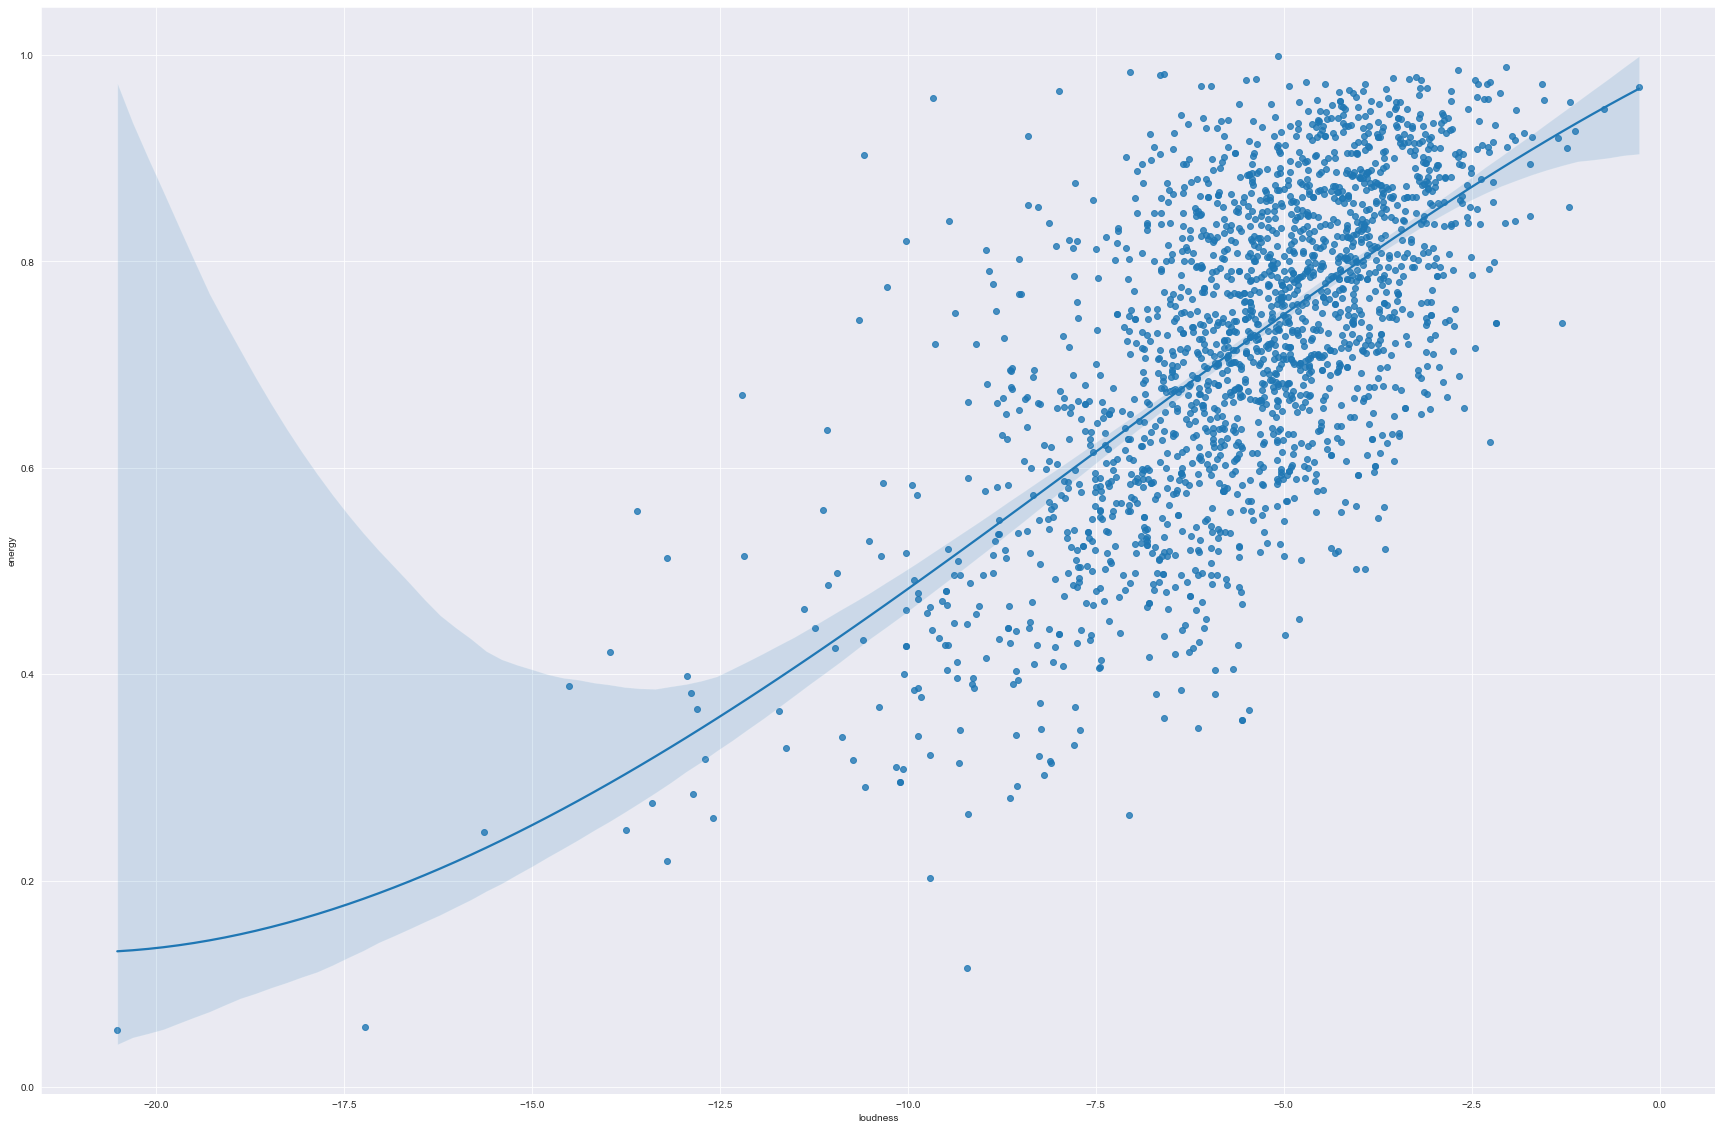

In [680]:
relationship('loudness', 'energy')

## In-Time

<AxesSubplot:xlabel='year'>

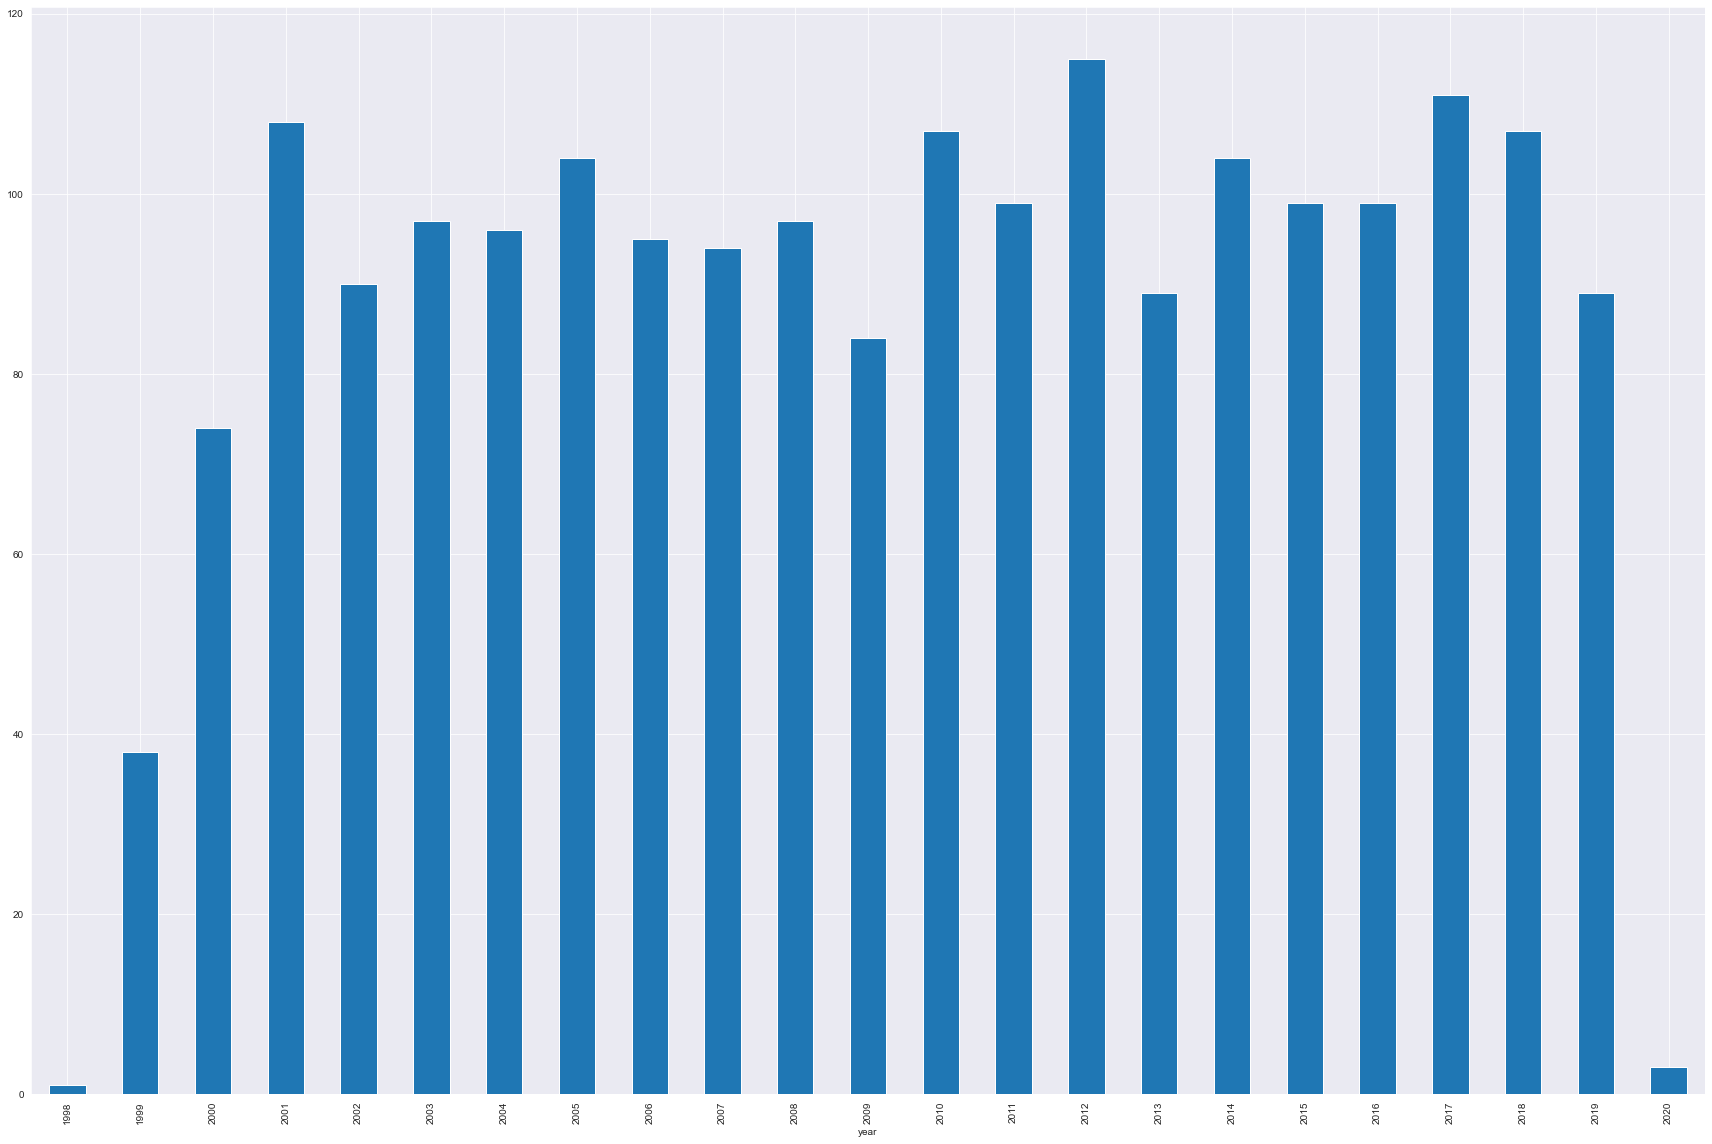

In [153]:
df.groupby('year').size().plot(kind='bar')

<AxesSubplot:xlabel='year'>

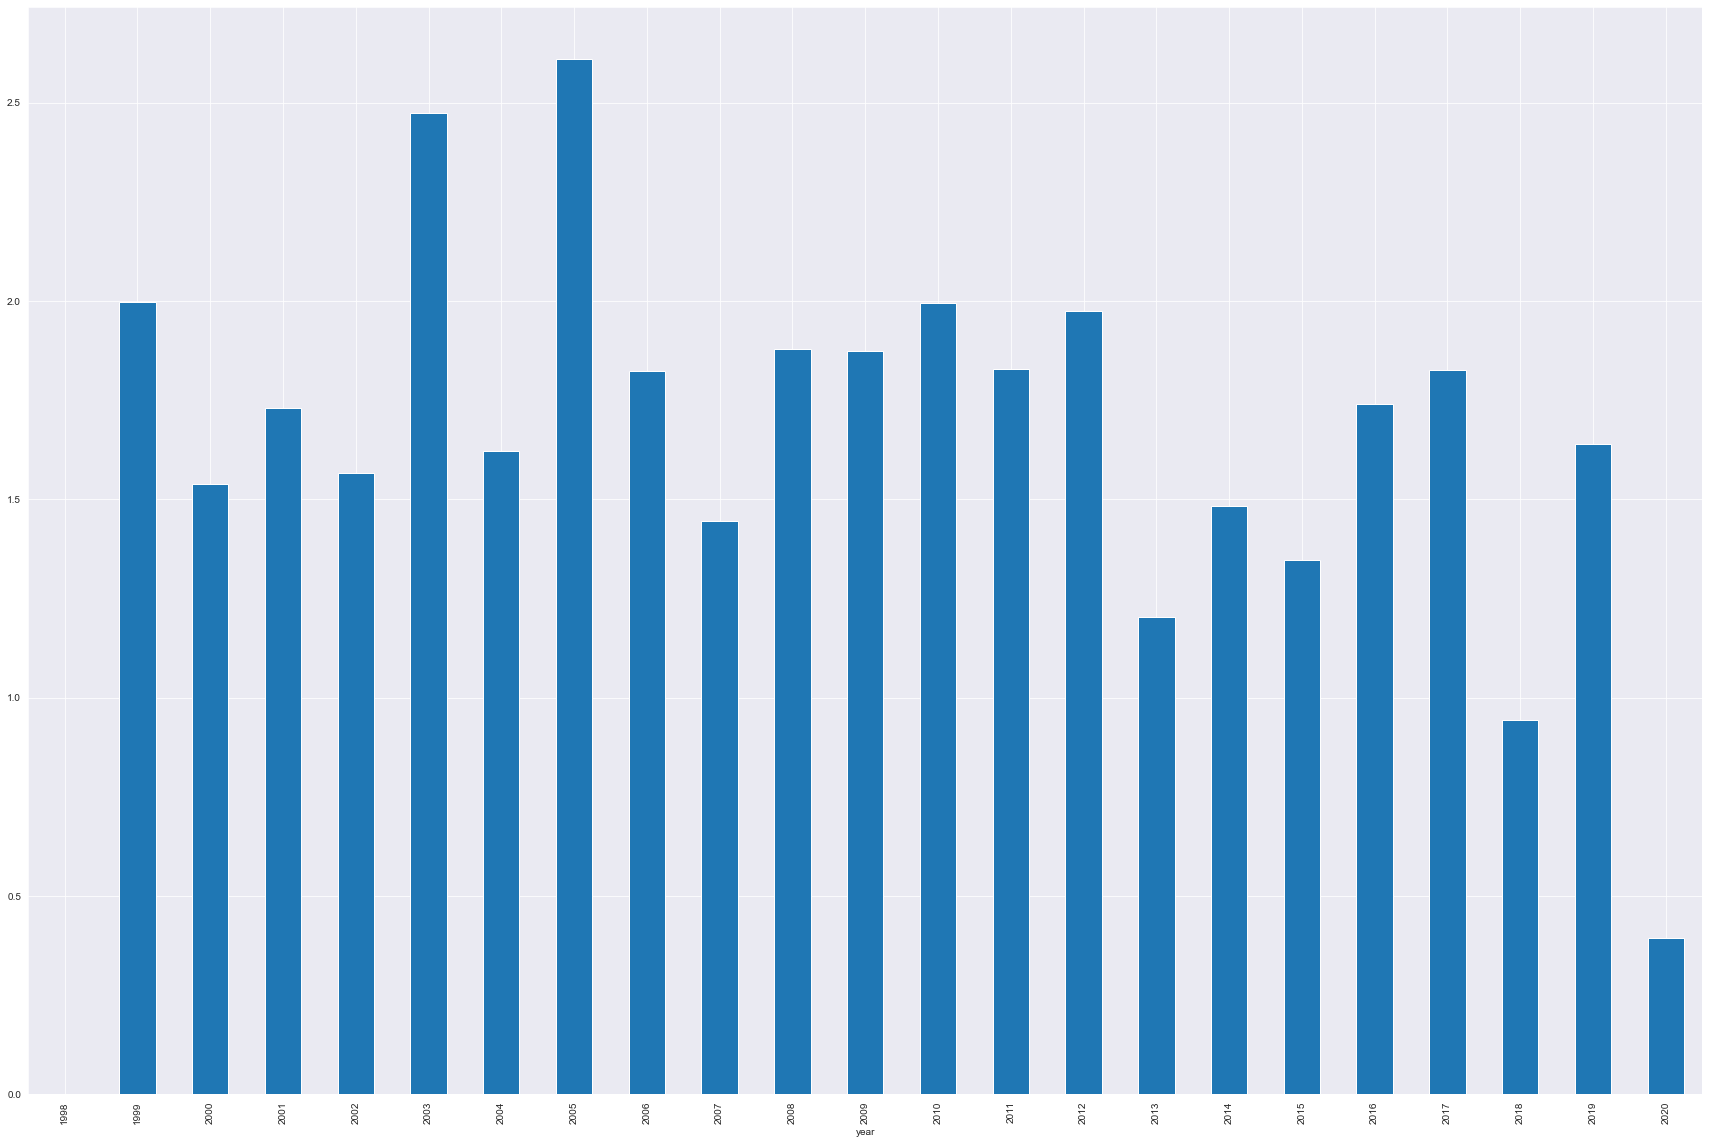

In [172]:
df.drop(columns=antinumerics.columns).groupby('year').apply(lambda x: x.std() / x.mean().abs()).fillna(0).T.mean().plot(kind='bar')

<AxesSubplot:>

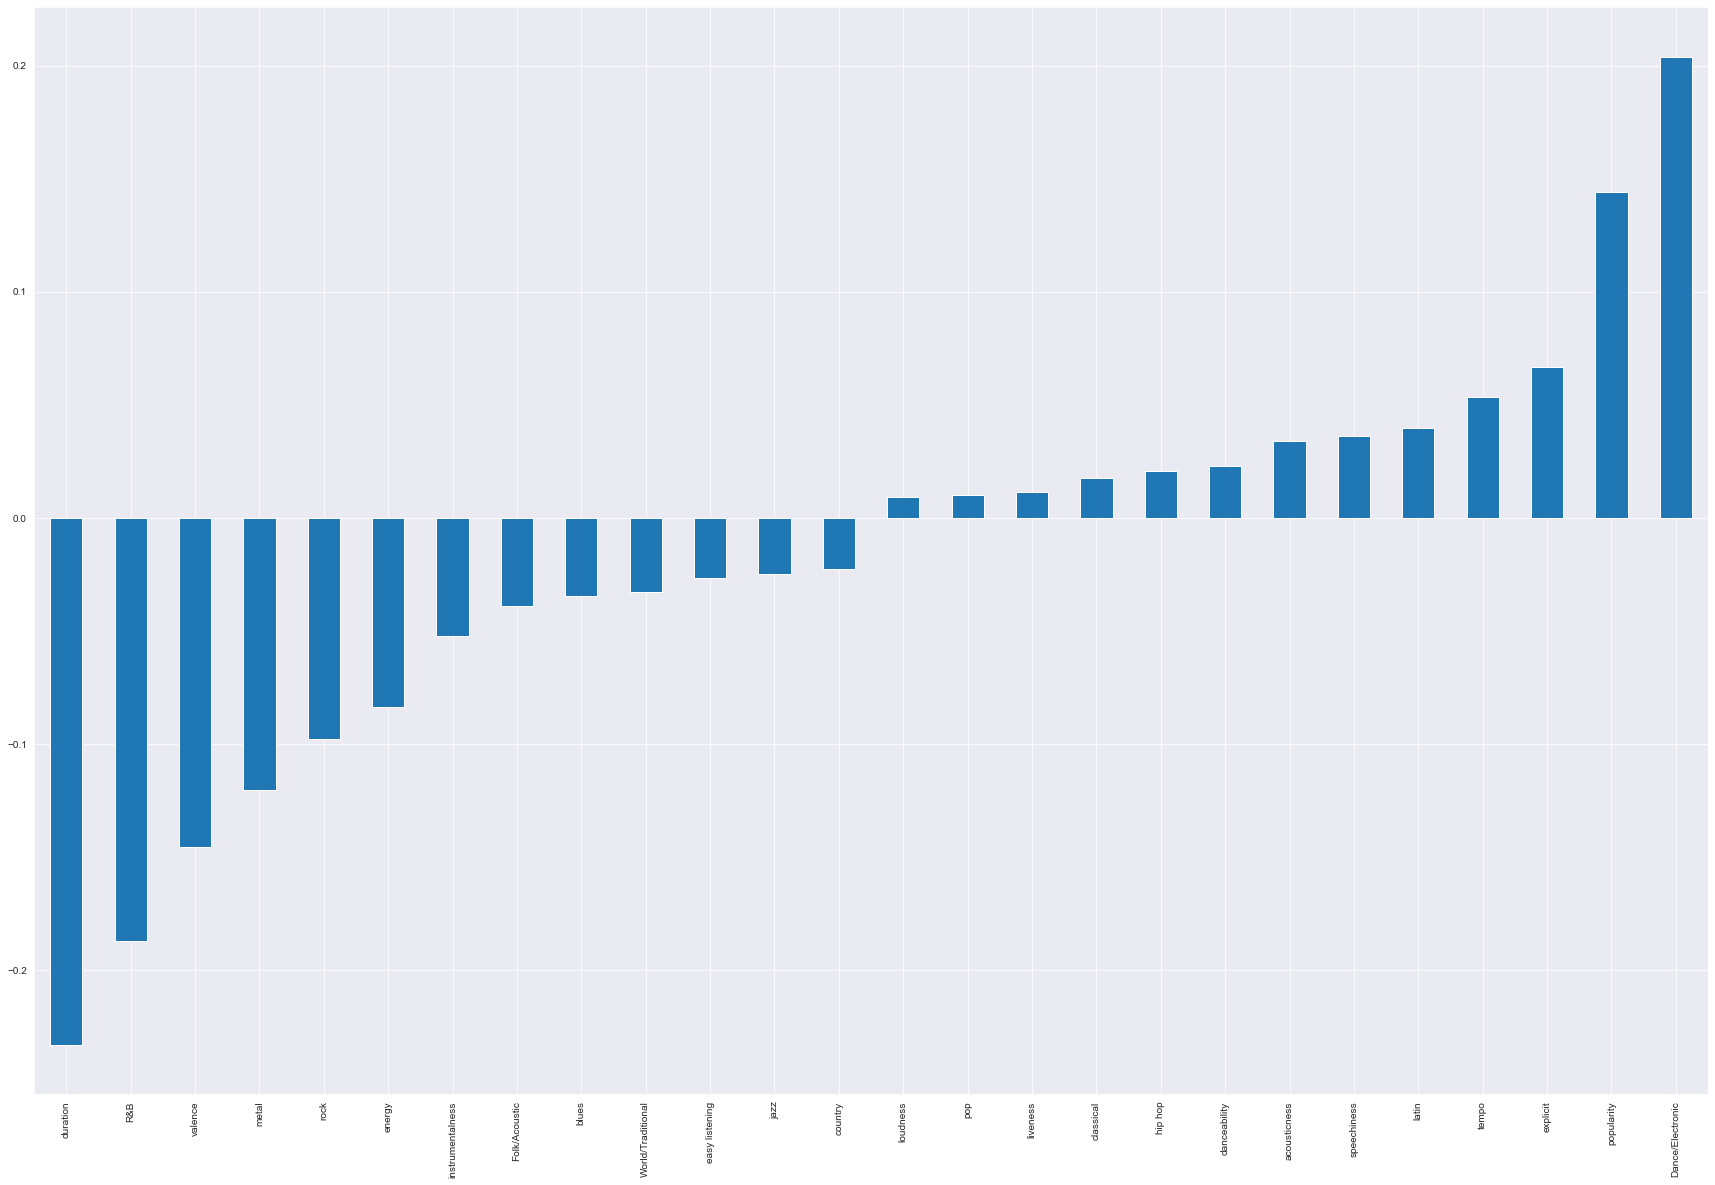

In [92]:
df.corr(method='kendall')['year'].sort_values().drop('year').plot(kind='bar')

In [131]:
rank_test_results = df.drop(columns=['year', 'season']).apply(lambda column: stats.kendalltau(df['year'], column)).T
rank_test_results.columns = ['tau', 'pvalue']
significant_change_in_time = rank_test_results[rank_test_results['pvalue'] < ALPHA].sort_values('tau').index.values

In [132]:
in_time = lambda column: sns.relplot(data=df, x='season', y=column, kind='line').set(title=rank_test_results.loc[column, 'tau'])

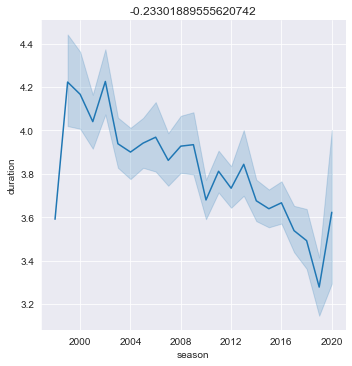

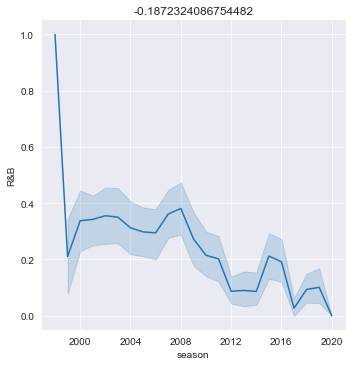

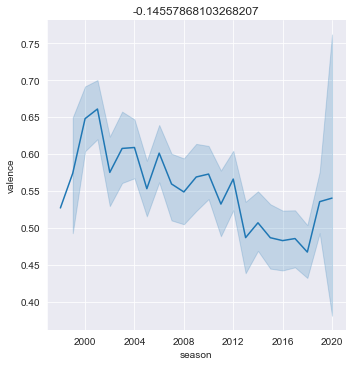

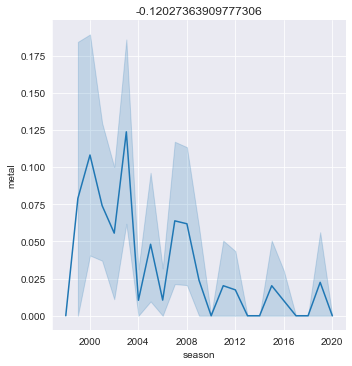

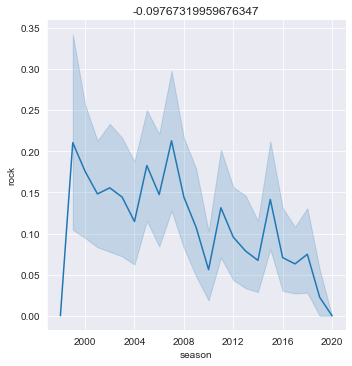

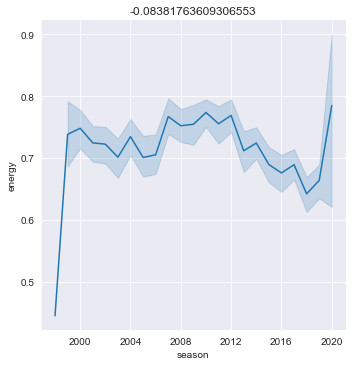

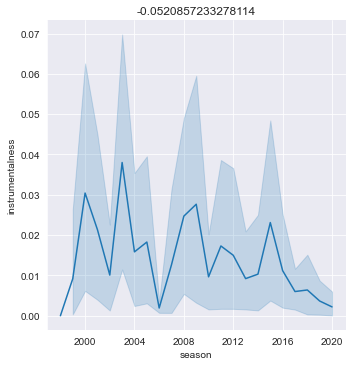

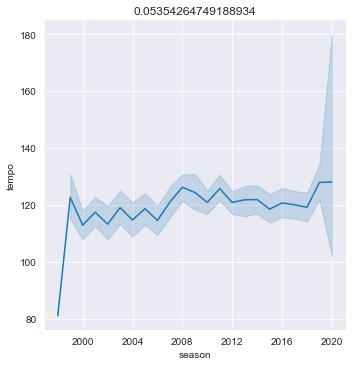

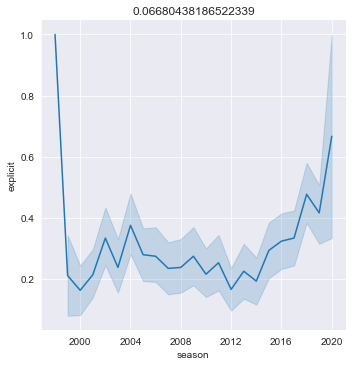

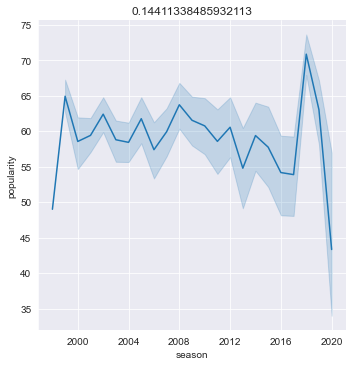

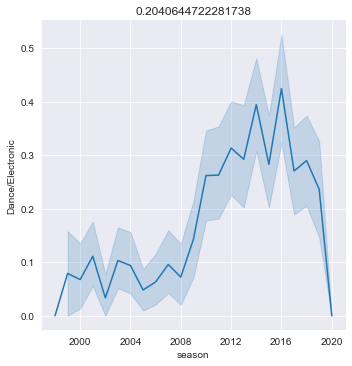

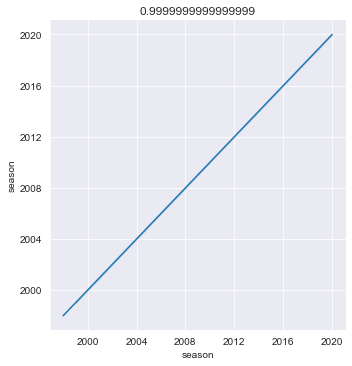

In [133]:
for column in significant_change_in_time:
    in_time(column)

In [212]:
def centroid(subdf):
    
    spreads = subdf.drop(columns=antinumerics.columns).apply(lambda x: (x - x.mean()) ** 2 / x.var()).T.sum().apply(np.sqrt)
    min_spread = np.argmin(spreads)
    return subdf.iloc[min_spread], spreads.values[min_spread]

In [215]:
avg_songs = {year: centroid(songs)[0] for year, songs in df.groupby('year')}

In [222]:
avg_songs[1999]

artist                        Céline Dion
song                 That's the Way It Is
explicit                            False
year                                 1999
popularity                             64
danceability                        0.634
energy                              0.886
key                                     9
loudness                           -5.424
mode                                    1
speechiness                        0.0434
acousticness                        0.154
instrumentalness                      0.0
liveness                            0.118
valence                             0.577
tempo                               93.04
pop                                  True
rock                                False
country                             False
metal                               False
hip hop                             False
R&B                                 False
Dance/Electronic                    False
Folk/Acoustic                     

In [223]:
avg_songs[2004]

artist                    Britney Spears
song                      My Prerogative
explicit                           False
year                                2004
popularity                            53
danceability                       0.749
energy                             0.938
key                                   10
loudness                          -4.423
mode                                   0
speechiness                        0.118
acousticness                      0.0127
instrumentalness                0.000002
liveness                           0.103
valence                            0.619
tempo                            111.014
pop                                 True
rock                               False
country                            False
metal                              False
hip hop                            False
R&B                                False
Dance/Electronic                   False
Folk/Acoustic                      False
easy listening  

In [224]:
avg_songs[2009]

artist                         Alexandra Burke
song                 Bad Boys (feat. Flo Rida)
explicit                                 False
year                                      2009
popularity                                  57
danceability                              0.67
energy                                   0.866
key                                          1
loudness                                -3.684
mode                                         1
speechiness                             0.0538
acousticness                            0.0115
instrumentalness                           0.0
liveness                                 0.358
valence                                  0.636
tempo                                  140.029
pop                                       True
rock                                     False
country                                  False
metal                                    False
hip hop                                  False
R&B          

In [225]:
avg_songs[2014]

artist                       OneRepublic
song                      Counting Stars
explicit                           False
year                                2014
popularity                            62
danceability                       0.663
energy                             0.705
key                                    1
loudness                          -4.972
mode                                   0
speechiness                       0.0385
acousticness                      0.0654
instrumentalness                     0.0
liveness                           0.117
valence                            0.477
tempo                            122.014
pop                                 True
rock                               False
country                            False
metal                              False
hip hop                            False
R&B                                False
Dance/Electronic                   False
Folk/Acoustic                      False
easy listening  

In [226]:
avg_songs[2019]

artist                                                  Ed Sheeran
song                 Cross Me (feat. Chance the Rapper & PnB Rock)
explicit                                                      True
year                                                          2019
popularity                                                      64
danceability                                                 0.746
energy                                                       0.787
key                                                              4
loudness                                                    -6.373
mode                                                             1
speechiness                                                   0.12
acousticness                                                 0.214
instrumentalness                                               0.0
liveness                                                    0.0669
valence                                                      0

## Genres

<AxesSubplot:xlabel='genre'>

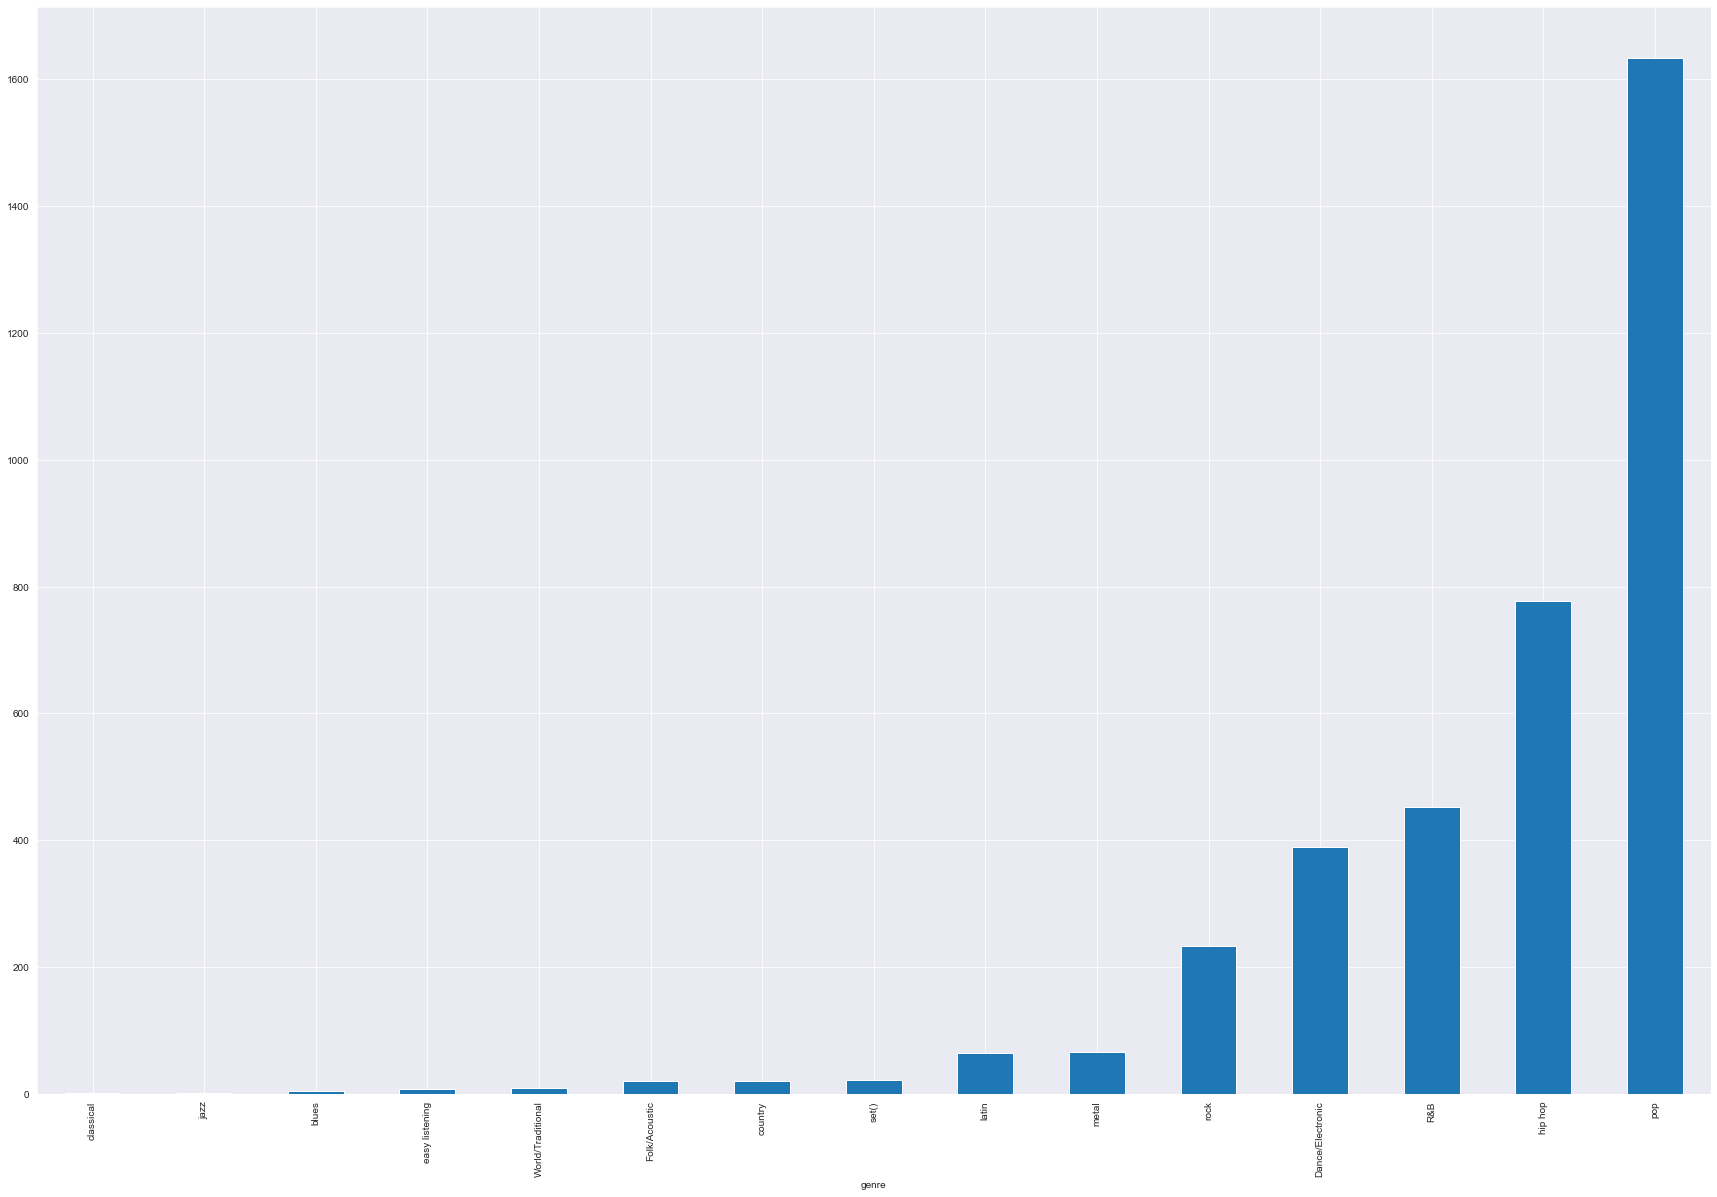

In [418]:
pd.DataFrame(genres.explode()).groupby('genre').size().sort_values().plot(kind='bar')

In [424]:
large_genres = pd.DataFrame(genres.explode()).groupby('genre').size().nlargest(7).index.values

In [249]:
normalized = (numerics - numerics.mean()) / numerics.std()
normalized = normalized.drop(columns=['year', 'popularity'])

In [538]:
similarity = pd.DataFrame(cosine_similarity(normalized, normalized))
similarity['genre'] = genres
similarity = similarity.explode('genre')
similarity = similarity[similarity['genre'].isin(large_genres)]

In [548]:
def group_similarity(first_genre, second_genre):
    
    first_indices = np.array(similarity[similarity['genre'] == first_genre].index.values)
    second_indices = np.array(similarity[similarity['genre'] == second_genre].index.values)
    similarity_group = np.array(similarity.drop(columns=['genre']))[first_indices, :][:, second_indices]
    
    return (np.amax(similarity_group, 0).mean() + np.amax(similarity_group, 1).mean()) / (len(first_indices) + len(second_indices))

In [549]:
similarities = {tuple(genre_pair): group_similarity(*genre_pair) for genre_pair in combinations(large_genres, 2)}

In [550]:
genre_sim = pd.DataFrame(np.ones((len(large_genres), len(large_genres))))
genre_sim.columns = large_genres
genre_sim.index = large_genres

In [551]:
def assign_sim(keyval):
    
    genres = keyval[0]
    sim = keyval[1]
    genre_sim.loc[genres] = sim
    genre_sim.loc[genres[::-1]] = sim

In [552]:
np.apply_along_axis(assign_sim, 1, np.array(list(similarities.items())));

C:\Users\mikol\AppData\Local\Temp\ipykernel_7704\1730725462.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [553]:
dict(sorted(similarities.items(), key=lambda item: item[1]))

{('metal', 'latin'): 0.7717524909534172,
 ('Dance/Electronic', 'metal'): 0.7927254449210785,
 ('rock', 'metal'): 0.7952283692975821,
 ('R&B', 'metal'): 0.7962276592585031,
 ('rock', 'latin'): 0.8062644815465775,
 ('R&B', 'latin'): 0.8162397263748487,
 ('hip hop', 'metal'): 0.8174172373328095,
 ('Dance/Electronic', 'latin'): 0.8175704582265273,
 ('pop', 'metal'): 0.8201072049748778,
 ('hip hop', 'latin'): 0.8277817676684811,
 ('pop', 'latin'): 0.8392209131245293,
 ('R&B', 'Dance/Electronic'): 0.862075741429364,
 ('R&B', 'rock'): 0.864218149088845,
 ('Dance/Electronic', 'rock'): 0.8658131702661435,
 ('hip hop', 'Dance/Electronic'): 0.8806675658963972,
 ('hip hop', 'rock'): 0.8847826636615816,
 ('pop', 'Dance/Electronic'): 0.8903796897282019,
 ('pop', 'rock'): 0.8928874064761027,
 ('hip hop', 'R&B'): 0.930644173142308,
 ('pop', 'hip hop'): 0.9419048621194547,
 ('pop', 'R&B'): 0.9476721825989245}

In [554]:
px.imshow(genre_sim, color_continuous_scale='viridis_r')

In [533]:
embed = pd.DataFrame(Isomap().fit_transform(normalized))
embed.columns = ['x', 'y']

In [534]:
embed['genre'] = genres
embed = embed.explode('genre')
embed = embed[embed['genre'].isin(large_genres)]
embed.index = np.arange(len(embed))

In [535]:
px.scatter(embed, x='x', y='y', color='genre')

<AxesSubplot:xlabel='x', ylabel='y'>

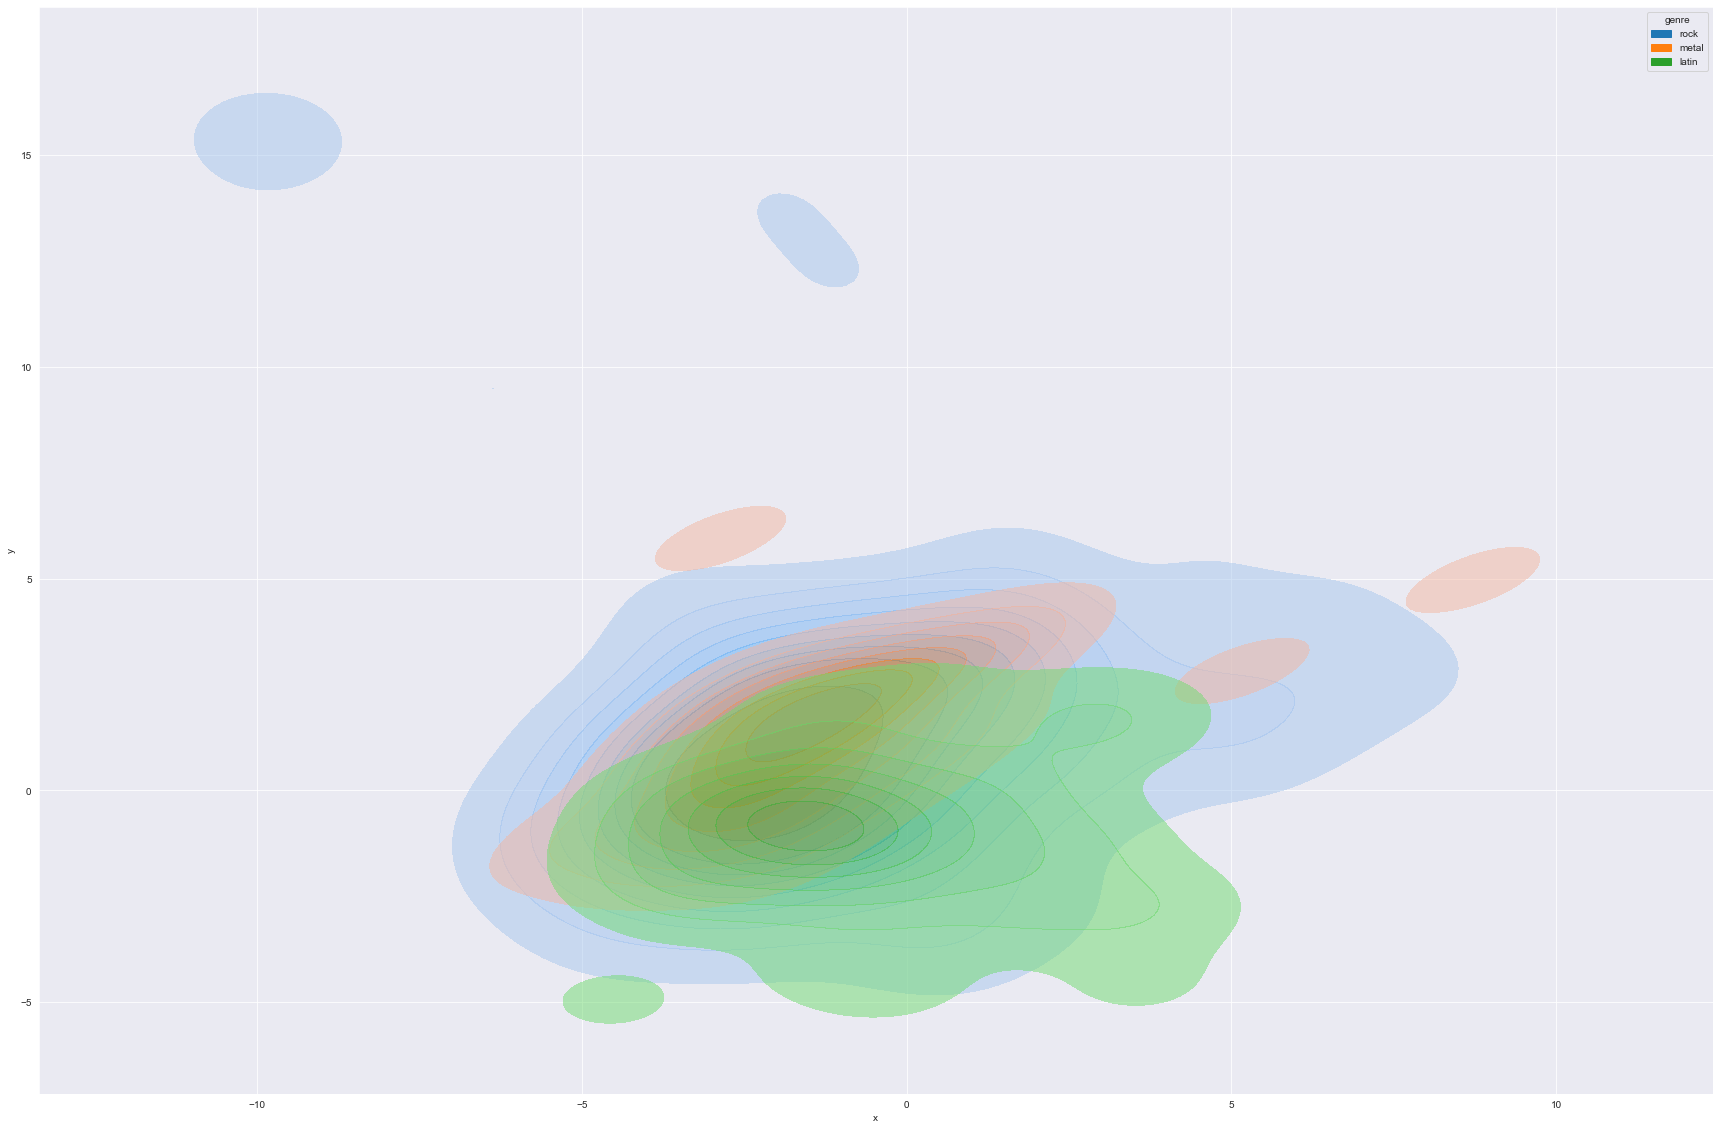

In [541]:
sns.kdeplot(data=embed[embed['genre'].isin(['metal', 'rock', 'latin'])], x='x', y='y', hue='genre', fill=True, alpha=.5)

In [683]:
def t_tests(flag_column):
    
    df_true = df[df[flag_column]]
    df_false = df[~df[flag_column]]
    
    return np.vectorize(lambda column: stats.ttest_ind(df_true[column], df_false[column])[0])(numerics.columns)

In [687]:
t_stat_feature = np.nan_to_num(np.vectorize(t_tests, signature='()->(n)')(booleans.columns))
t_stat_class = t_stat_feature.T

In [688]:
def prepare_t(t_init, index, columns):
    
    t_stat = (t_init - t_init.mean(axis=0)) / t_init.std(axis=0)
    t_stat = pd.DataFrame(t_stat)
    t_stat.index = index
    t_stat.columns = columns
    
    return t_stat

In [689]:
t_stat_feature = prepare_t(t_stat_feature, booleans.columns, numerics.columns)
t_stat_class = prepare_t(t_stat_class, numerics.columns, booleans.columns)

C:\Users\mikol\AppData\Local\Temp\ipykernel_7704\2291601277.py:3: RuntimeWarning:

invalid value encountered in true_divide



In [690]:
px.imshow(t_stat_feature, color_continuous_scale='RdBu', color_continuous_midpoint=0)

In [691]:
px.imshow(t_stat_class, color_continuous_scale='RdBu', color_continuous_midpoint=0)

In [696]:
def binary_box(binary_column, numeric_column):
    
    return sns.catplot(data=df, x=binary_column, y=numeric_column, kind='violin')

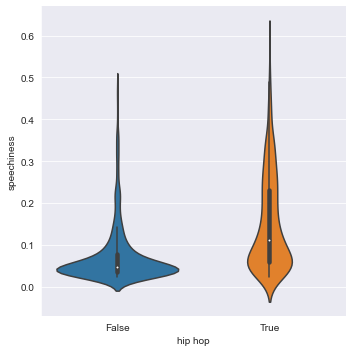

In [701]:
binary_box('hip hop', 'speechiness')

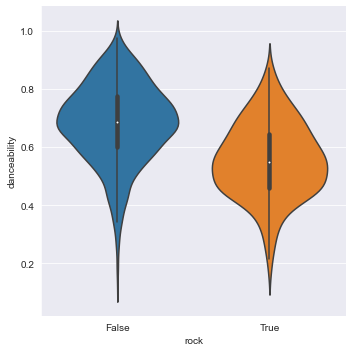

In [702]:
binary_box('rock', 'danceability')